# Implementing an improved lower bound based on an LP

Unfortunately, the idea failed. But it may show how to use the interface to implement improved lower bounds.

In [12]:
# import the stuff
from cetsp_bnb2 import Circle, Instance, compute_tour_by_2opt, branch_and_bound, Point, plot_solution, compute_tour_from_sequence, TripleMap

In [13]:
# Load instances
import aemeasure
db_ = aemeasure.Database("instance_db")
data = db_.load()
instances = {instance["instance"]: instance  for instance in data}

In [14]:
list(instances.keys())

['srpg_octa0000092/upper_bound_70.json',
 'srpg_octa0000092/upper_bound_27.json',
 'srpg_octa0000092/upper_bound_31.json',
 'srpg_octa0000092/upper_bound_66.json',
 'srpg_octa0000092/upper_bound_5.json',
 'srpg_octa0000092/upper_bound_9.json',
 'srpg_octa0000092/upper_bound_11.json',
 'srpg_octa0000092/upper_bound_46.json',
 'srpg_octa0000092/upper_bound_50.json',
 'srpg_octa0000092/lower_bound_2.json',
 'srpg_octa0000092/upper_bound_51.json',
 'srpg_octa0000092/upper_bound_47.json',
 'srpg_octa0000092/upper_bound_8.json',
 'srpg_octa0000092/upper_bound_10.json',
 'srpg_octa0000092/upper_bound_4.json',
 'srpg_octa0000092/upper_bound_67.json',
 'srpg_octa0000092/upper_bound_30.json',
 'srpg_octa0000092/upper_bound_26.json',
 'srpg_octa0000092/upper_bound_71.json',
 'srpg_octa0000092/upper_bound_17.json',
 'srpg_octa0000092/upper_bound_40.json',
 'srpg_octa0000092/upper_bound_56.json',
 'srpg_octa0000092/upper_bound_21.json',
 'srpg_octa0000092/upper_bound_37.json',
 'srpg_octa0000092/up

In [15]:
instance = Instance([Circle(Point(float(d["x"]), float(d["y"])), float(d["radius"])) for d in instances['srpg_octa0000092/lower_bound_2.json']["circles"]])

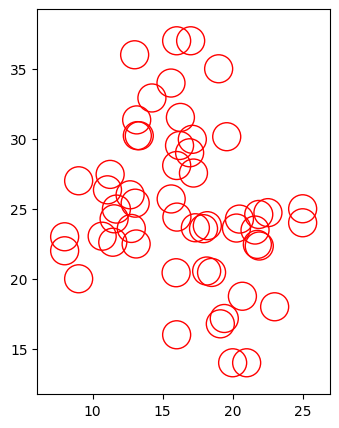

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plot_solution(plt.gca(), instance, [])

In [17]:
# compute an initial solution via 2opt
initial_solution = compute_tour_by_2opt(instance)

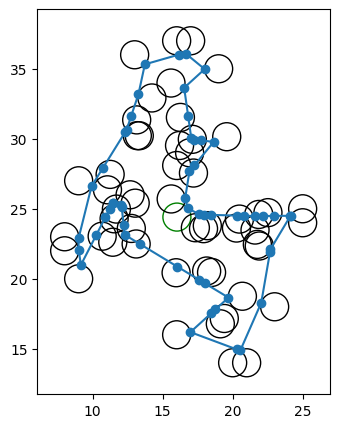

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plot_solution(plt.gca(), instance, initial_solution, highlight=[15])

In [19]:
# code for computing the improved lower bounds

import typing
import networkx as nx
import itertools

import gurobipy as gp  # requires gurobi to be installed via conda.
from gurobipy import GRB

class TripleVars:
    def __init__(self, graph: nx.Graph, model: gp.Model):
        self.graph = graph
        self._vars = model.addVars(self.all_triples(), lb=0, ub=1.0, vtype=GRB.BINARY)
        self.model = model

    def all_triples(self):
        for v in self.graph.nodes:
            for n0, n1 in itertools.combinations(self.graph.neighbors(v),2):
                yield min(n0, n1), v, max(n0, n1)

    def get(self, n0, v, n1):
        n0, n1 = min(n0, n1), max(n0, n1)
        return self._vars[(n0, v, n1)]

    def var_sum(self, source, target=None):
        if target is None:
            return sum(self.get(n0, source, n1) for n0, n1  in itertools.combinations(self.graph.neighbors(source),2))
        return sum(self.get(n, source, target) for n in self.graph.neighbors(source) if n!=target)
    
    def get_solution(self, lazy=False):
        graph =  nx.Graph()
        for t,x in self._vars.items():
            val = self.model.cbGetSolution(x) if lazy else x.X
            if val > 0.01:
                graph.add_edge(t[0],  t[1])
                graph.add_edge(t[1], t[2])
        return graph


class LowerBoundLp:
    def __init__(self, triple_map: TripleMap, sequence: typing.List[int], sample: typing.List[int]):
        self.model = gp.Model()
        self.graph = self._create_graph(sequence, sample)
        self.vars = TripleVars(self.graph, self.model)
        self.triple_map = triple_map
        self._enforce_coverage()
        self._enforce_flow()
        self._minimize_costs()
    
    def _minimize_costs(self):
        obj = sum(self.triple_map.get_cost(n0,v,n1)*self.vars.get(n0,v,n1) for n0,v,n1 in self.vars.all_triples())
        self.model.setObjective(obj, GRB.MINIMIZE)
    
    def _enforce_coverage(self):
        for v in self.graph:
            self.model.addConstr(self.vars.var_sum(v)==1)
    
    def _enforce_flow(self):
        for v,w in self.graph.edges:
            self.model.addConstr(self.vars.var_sum(v,w)==self.vars.var_sum(w,v))
            

    def _create_graph(self, sequence, sample):
        graph = nx.Graph()
        # the current tour
        for i, v in enumerate(sequence):
            graph.add_edge(v, sequence[(i+1)%len(sequence)])

        # connect sample to all other
        for v in sample:
            nodes = list(graph.nodes)
            for n in nodes:
                graph.add_edge(v,n)

        return graph
    
    def prohibit_subtour(self, subset, lazy=False):
        constr =  0
        for v in subset:
            for n in self.graph.neighbors(v):
                if n in subset:
                    continue
                constr += self.vars.var_sum(v, n)
        if lazy:
            self.model.cbLazy(constr>=2)
        else:
            self.model.addConstr(constr>=2)
                
        
    
    def optimize(self):
        def cb(model, where):
            if where==GRB.Callback.MIPSOL:
                g = self.vars.get_solution(lazy=True)
                cc = list(nx.connected_components(g))
                if len(cc)==1:
                    return
                else:
                    for c in cc:
                        self.prohibit_subtour(c, lazy=True)
        self.model.setParam("OutputFlag", False)
        self.model.Params.LazyConstraints = 1
        connected = False
        while not connected:
            self.model.optimize()
            g = self.vars.get_solution(lazy=False)
            cc = list(nx.connected_components(g))
            if len(cc)==1:
                connected = True
                break
            else:
                #print(cc)
                for c in cc:
                    self.prohibit_subtour(c, lazy=False)
        return self.model.objVal

Using ChFarthestCircle-Branching
Using DfsBfs search
Starting with root node of size 14
i	LB	|	UB


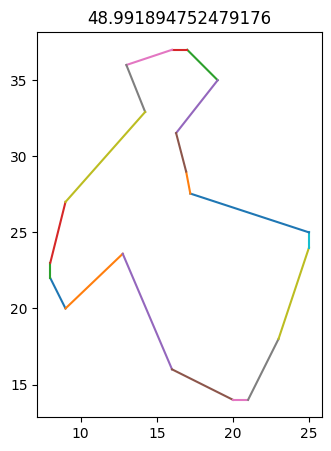

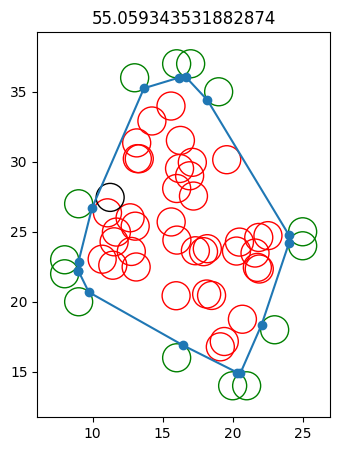

0	60.2736	|	74.4431


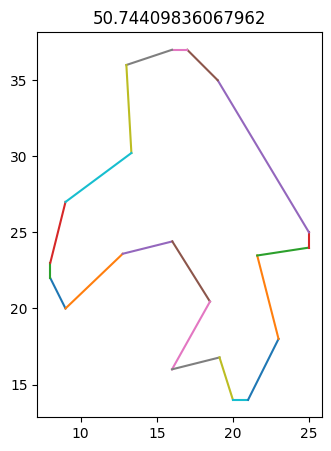

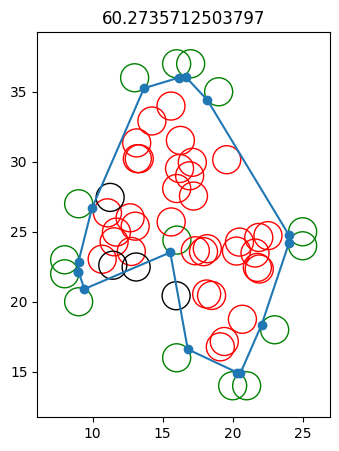

1	60.3318	|	74.4431


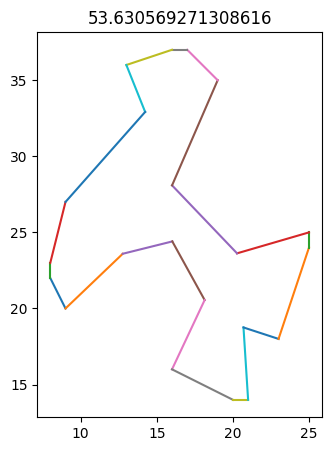

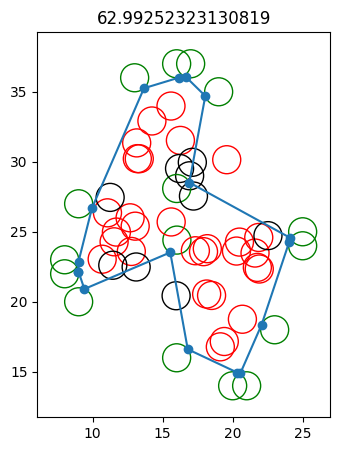

2	60.3318	|	74.4431


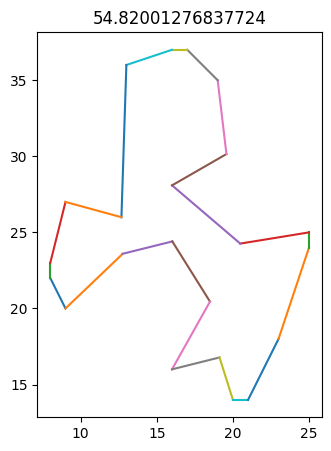

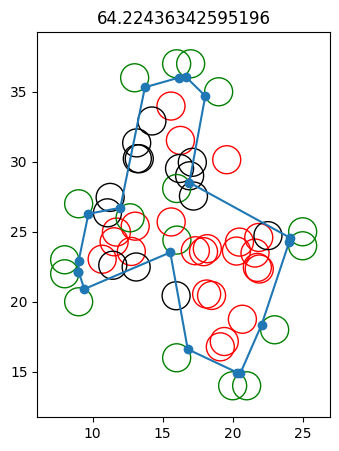

3	60.3318	|	74.4431
4	60.3318	|	74.4431
5	60.3318	|	74.4431
6	60.3318	|	74.4431
7	60.3318	|	74.4431
8	60.3318	|	74.4431
9	60.3318	|	74.4431
10	60.3318	|	74.4431
20	60.3318	|	74.4431


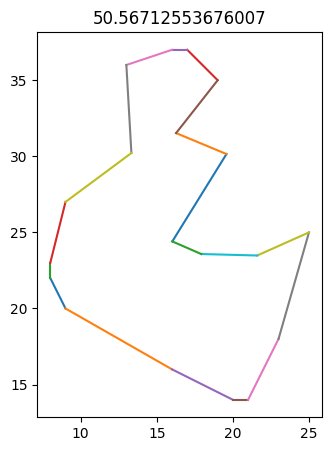

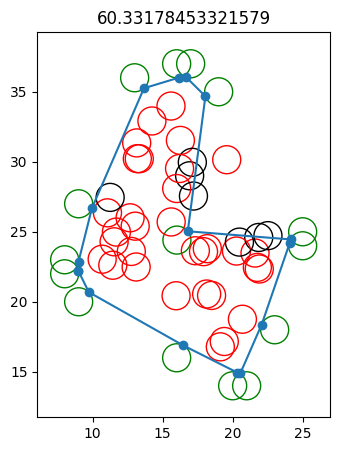

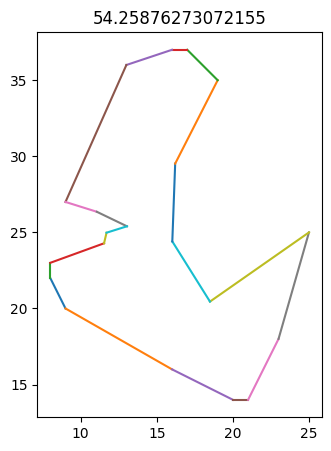

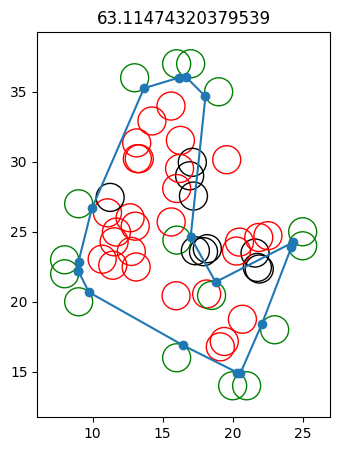

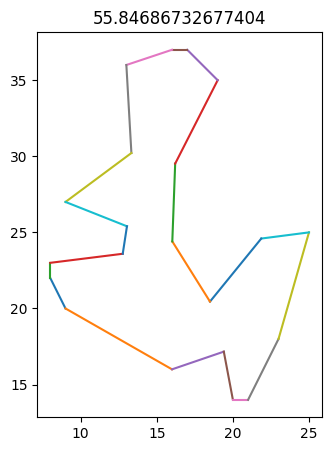

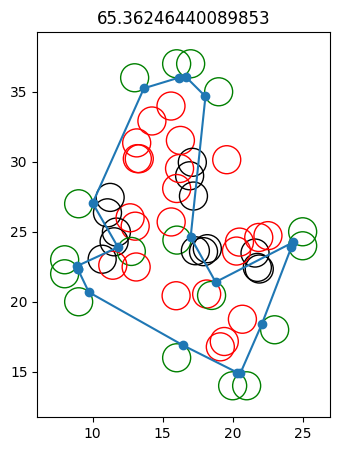

30	61.21	|	71.0406
40	61.21	|	71.0406


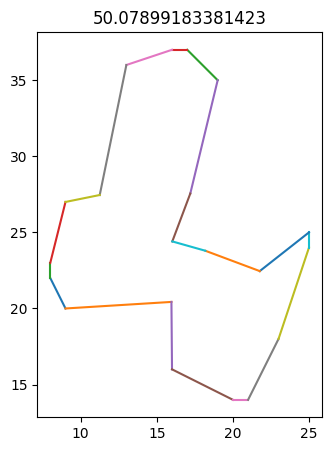

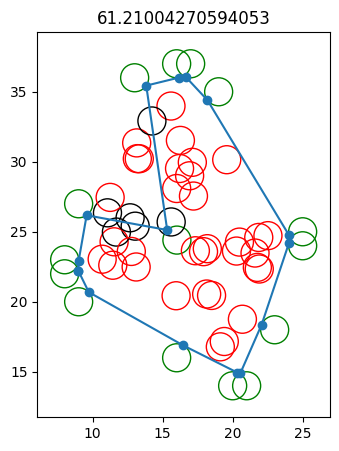

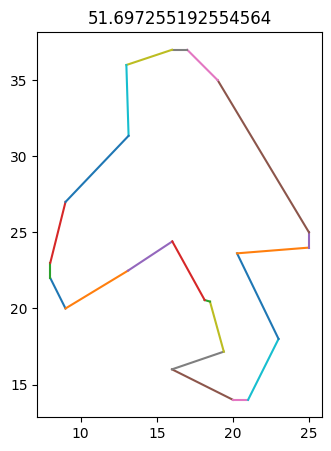

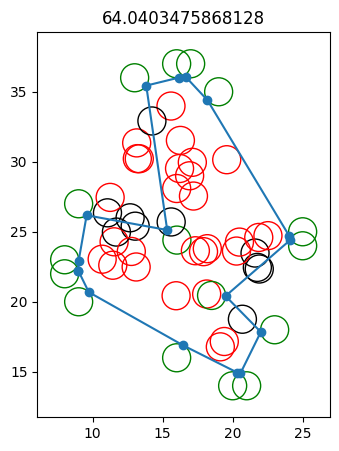

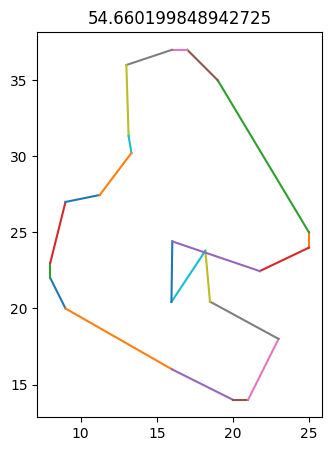

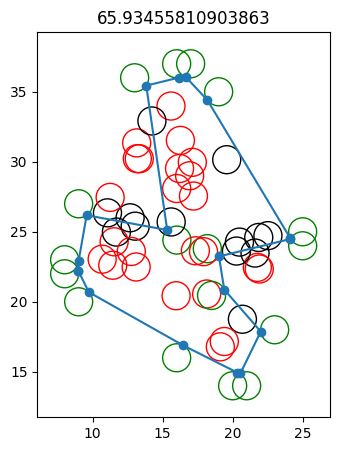

50	62.4745	|	69.7232


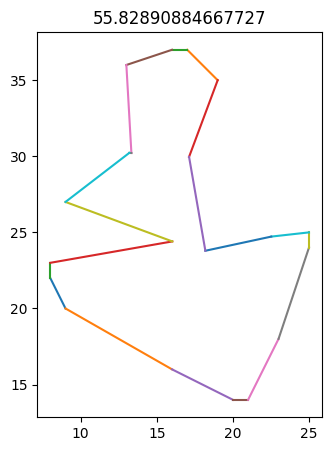

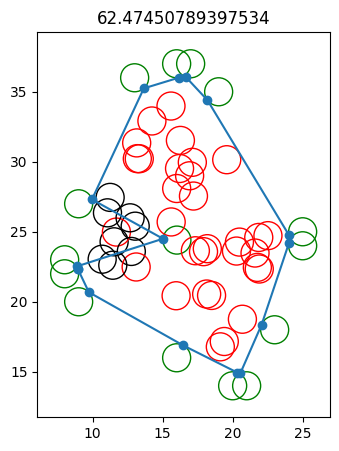

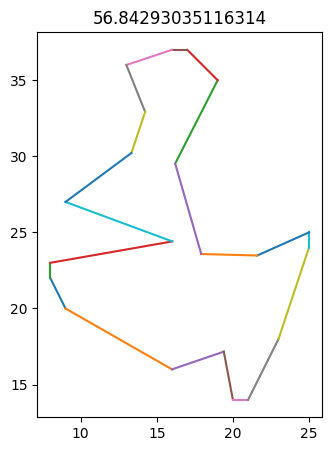

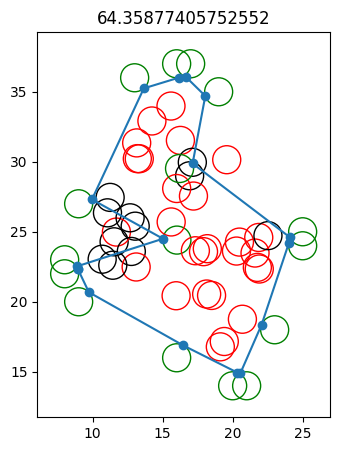

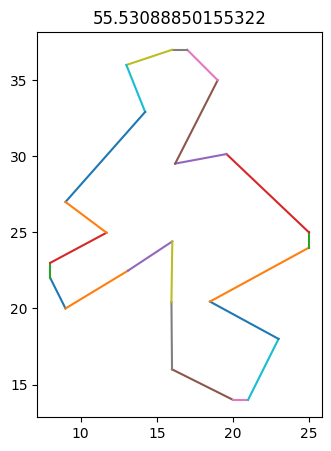

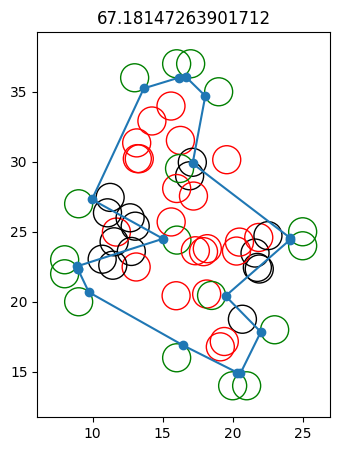

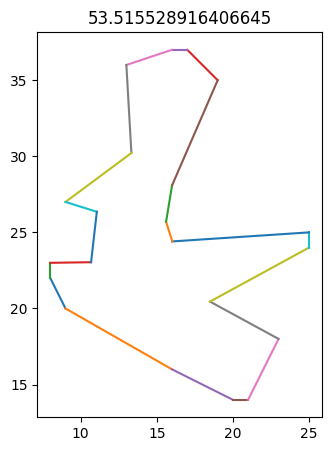

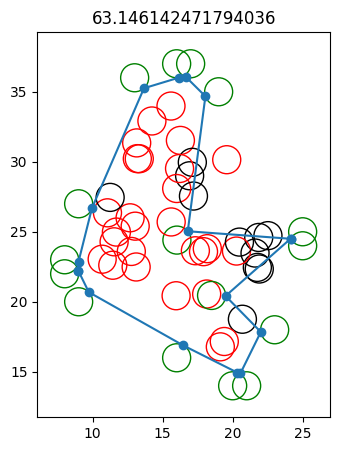

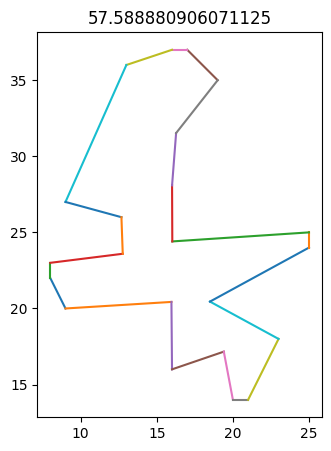

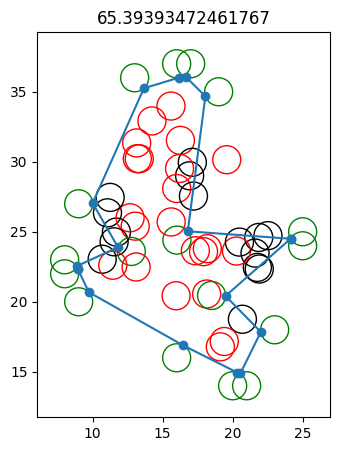

60	63.1555	|	69.7232
70	63.1555	|	69.7232


KeyboardInterrupt: 

In [22]:
# adding the improved lower bounds to the BnB algorithm in the callback.

import random
timelimit = 220
node_values = []
tm = TripleMap(instance)

def cb(event):
    # only apply to nodes close to the root as it is performing bad for deeper nodes
    # (this may be the reason why it doesn't help at all)
    if event.current_node.depth()>3:
        return
    
    # trigger_lazy_computation the improved lower bound based on the current solution and its missing circles
    global tm
    lb = event.get_lower_bound()
    missing_circles = [i for i,circle in enumerate(instance.circles()) if event.current_node.get_relaxed_solution().distance(circle) >= 0.1]
    missing_circles = list(random.sample(missing_circles, min(5, len(missing_circles))))
    lp = LowerBoundLp(tm, event.current_node.get_spanning_sequence(), missing_circles)
    lp_lb = lp.optimize()

    # add lower bound to node
    event.current_node.add_lower_bound(lp_lb)

    # just some plotting to look at what is happening. Slows things down.
    plt.figure(figsize=(5, 5))
    plt.gca().set_aspect("equal", "box")
    plt.title(lp_lb)
    for i,j in lp.vars.get_solution().edges:
            plt.plot([instance[i].center.x,instance[j].center.x],[instance[i].center.y,instance[j].center.y], "-")
    plt.show()
    plt.figure(figsize=(5, 5))
    plot_solution(plt.gca(), instance, event.get_relaxed_solution(), highlight=event.current_node.get_fixed_sequence())
    plt.title(event.get_relaxed_solution().length())
    plt.show()
    plt.close()
        
opt_solution, lb = branch_and_bound(instance, cb, initial_solution, timelimit)

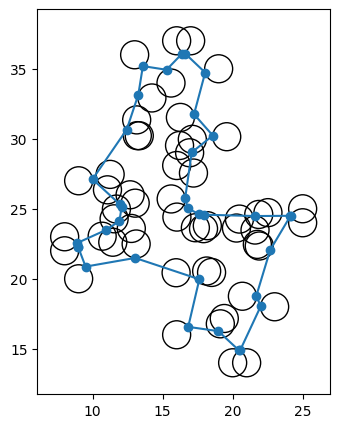

In [21]:
plt.figure(figsize=(5, 5))
plot_solution(plt.gca(), instance, opt_solution)